<a href="https://colab.research.google.com/github/rabbidave/Eliza-Thornberry-and-the-conformal-prediction-of-LLM-Behavior/blob/main/Eliza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install nonconformist numpy scikit-learn matplotlib seaborn

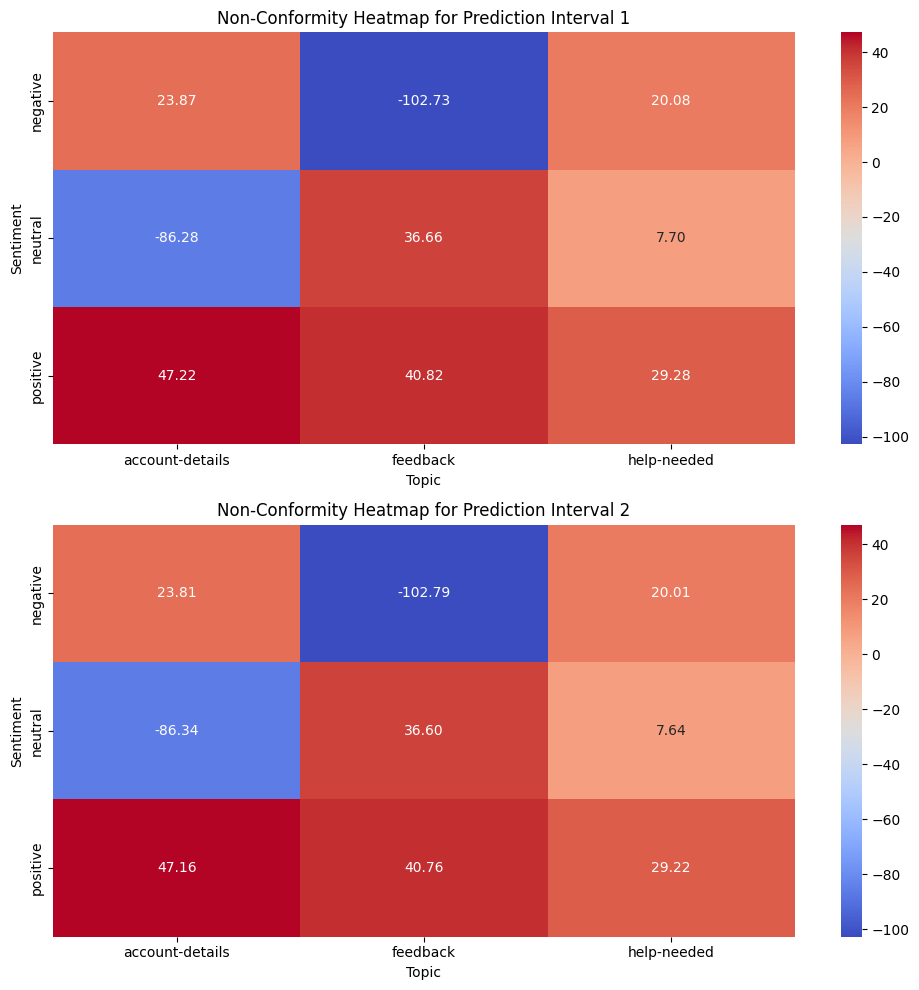

In [21]:
#Dependencies: pip install numpy scikit-learn nonconformist matplotlib seaborn pandas

# Import necessary libraries and modules
import numpy as np
import sklearn
from sklearn.linear_model import Ridge
from nonconformist.nc import RegressorNc
from nonconformist.icp import IcpRegressor
from nonconformist.nc import AbsErrorErrFunc
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

# Define constants
PREDICTION_INTERVAL_1 = 0.05
PREDICTION_INTERVAL_2 = 0.01

# Initialize Ridge Regression model
ridge = Ridge(alpha=1.0)

# Initialize Nonconformity function
nc = RegressorNc(ridge, AbsErrorErrFunc())

# Initialize Inverse Conformal Prediction model
icp = IcpRegressor(nc)

# Function to train the model
def train_model(X_train, y_train):
    icp.fit(X_train, y_train)

# Function to calibrate the model
def calibrate_model(X_calibrate, y_calibrate):
    icp.calibrate(X_calibrate, y_calibrate)

# Function to predict the range of values
def predict_range(X_test, prediction_interval):
    prediction = icp.predict(X_test, significance=prediction_interval)
    return prediction

# Function to process the data
def process_data(X_train, y_train, X_calibrate, y_calibrate, X_test):
    train_model(X_train, y_train)
    calibrate_model(X_calibrate, y_calibrate)
    prediction_range_1 = predict_range(X_test, PREDICTION_INTERVAL_1)
    prediction_range_2 = predict_range(X_test, PREDICTION_INTERVAL_2)
    return prediction_range_1, prediction_range_2

# Generate synthetic data for demonstration purposes
np.random.seed(42)
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)  # Increased number of samples

# Split the data into training, calibration, and test sets
X_train, X_calibrate, X_test = np.split(X, [int(.7*len(X)), int(.85*len(X))])
y_train, y_calibrate, y_test = np.split(y, [int(.7*len(y)), int(.85*len(y))])

# Train, calibrate, and predict
prediction_range_1, prediction_range_2 = process_data(X_train, y_train, X_calibrate, y_calibrate, X_test)

# Assign random sentiment and topic values
sentiments = ['positive', 'negative', 'neutral']
topics = ['account-details', 'help-needed', 'feedback']
sentiment_values = [random.choice(sentiments) for _ in range(len(X_test))]
topic_values = [random.choice(topics) for _ in range(len(X_test))]

# Create DataFrame for heatmap
df1 = pd.DataFrame({
    'Sentiment': sentiment_values,
    'Topic': topic_values,
    'Non-Conformity': prediction_range_1[:, 0]
})

df2 = pd.DataFrame({
    'Sentiment': sentiment_values,
    'Topic': topic_values,
    'Non-Conformity': prediction_range_2[:, 0]
})

# Create pivot tables for heatmap
df1_pivot = df1.pivot_table(index='Sentiment', columns='Topic', values='Non-Conformity')
df2_pivot = df2.pivot_table(index='Sentiment', columns='Topic', values='Non-Conformity')

# Create heatmaps
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.heatmap(df1_pivot, ax=axs[0], cmap='coolwarm', annot=True, fmt='.2f')
axs[0].set_title('Non-Conformity Heatmap for Prediction Interval 1')

sns.heatmap(df2_pivot, ax=axs[1], cmap='coolwarm', annot=True, fmt='.2f')
axs[1].set_title('Non-Conformity Heatmap for Prediction Interval 2')

plt.tight_layout()
plt.show()
